# Investigate a Dataset : Titanic

## Introduction
This project consists on the analysis of the dataset containing demographics and passenger information of 891 of 2224 passengers and crew on board of the Titanic. The data is provided by [Kaggle](https://www.kaggle.com/c/titanic/data) and a description of its structure can be found there. 

The question for the analysis suggested in the project details was *What factors made people more likely to survive?*, it seems indeed one of the most interesting questions one could ask about a disaster, however I'm gonna be a little more specific and try to focus on the following questions: Is there a difference on survival rate between different *classes*?, Who was more likely to survive, *males or females*?, Is there a particular *age range* that tended to survive most? and How did survival rate change across different *decks* of the ship?.

## Wrangling
The dataset is provided in the form of a csv file, to be able to use it in the easiest and most efficient way using Python I converted it into a Pandas DataFrame.

I also printed the first rows of the DataFrame to have a look at the different column names and at the kind of variable they contain. 

In [1]:
import pandas as pd
import numpy  as np

df = pd.read_csv("titanic_data.csv") # load the data into a dataframe using Pandas 
                                     # built-in function read_csv
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


For the sake of order, I changed some column names in order to follow the CamelCase convention that seemed to be followed by most columns and then I converted the *Survived* column type to bool, which will simplify its use later on.

In [2]:
df = df.rename(columns={"Parch":"ParCh", "Pclass":"PClass"})
df.loc[:,"Survived"] = df["Survived"].astype(bool)

From this point I proceded creating a different DataFrame for each question in order to always use the highest number possible of meaningful rows, and in case all the rows of the original DataFrame were meaningful (they contained valid data) I just kept the original. 

#### Classes
The DataFrame to answer the first question needed to contain all the rows where the column *PClass* is specified (i.e. is not null). Before proceding with the creation of the new DataFrame I counted all the invalid rows to check wether or not it was necessary to create it.

To count the invalid rows I first called the isnull() method on the *PClass* column, which returned a boolean Series of same lenght as the *PClass* column with True values where the column contained a null value and False otherwise. Then from this Series I called sum() that summed all the values, counting Falses as 0s and Trues as 1s.

In this case the sum() method returned 0, so I didn't need to create a new DataFrame to answer the question about passenger classes, since all the rows of the original one were valid to answer the question.

In [3]:
print "Null PClass count: ", df["PClass"].isnull().sum()

Null PClass count:  0


#### Gender
Here I used the same procedure I used for *PClass*, but this time on the *Sex* column, to check wheter or not I needed to create a new DataFrame, and again I didn't need to.

In [4]:
print "Null gender count: ", df["Sex"].isnull().sum()

Null gender count:  0


#### Ages
This time after counting the number of invalid rows (177) I realized I needed a new DataFrame containing just the rows with an *Age* value different than NaN.

So I proceded creating the new DataFrame by dropping from the original one all the rows containing NaNs on the *Age* column. I then printed the lenghts of the original and the new DataFrame just as a control measure.

In [5]:
print "Null age count: ", df["Age"].isnull().sum()

known_age_passengers = df.dropna(subset = ["Age"])
print "Passengers count: ", len(df)
print "Known age passengers count: ", len(known_age_passengers)

Null age count:  177
Passengers count:  891
Known age passengers count:  714


#### Decks
This time the invalid rows count was pretty high (687), and as before I created a new DataFrame taking into account the *Cabin* column.

In [6]:
print "Null cabin count: ", df["Cabin"].isnull().sum()

known_cabin_passengers = df.dropna(subset = ["Cabin"])
print "Passengers count: ", len(df)
print "Known cabin passengers count: ", len(known_cabin_passengers)

Null cabin count:  687
Passengers count:  891
Known cabin passengers count:  204


However here it wasn't enough just removing the invalid rows, becasue I was interested in the deck letters, while the cabins at the moment contain a string formed by the concatenation of the deck letter and the cabin number, and in some cases there's multiple cabin codes separated by a whitespace.

The first think I needed to do, was splitting the rows containing more than one cabin. I did that by creating a Series containing a list for each row of the *Cabin* column, creating a DataFrame out of this Series of lists, stacking it (which returns another Series), and finally replacing the original column with the obtained Series.

In [7]:
split_cabins = known_cabin_passengers["Cabin"].str.split(" ") # create a Series containing lists of cabins
split_cabins = split_cabins.apply(pd.Series, 1).stack() # split the lists in multiple rows 
split_cabins.index = split_cabins.index.droplevel(-1) # remove the extra index column
split_cabins.name = "Cabin"

del known_cabin_passengers["Cabin"] # delete the original column
known_cabin_passengers = known_cabin_passengers.join(split_cabins) # insert the new column

After that, I needed to split this new column into two different columns, one for the deck letter and another one for the cabin number. So I created two Series one containing the first letter of each string in the *Cabin* column (because the deck is always the first letter of the cabin code) and the other one containing the remaining part of the string. I then replaced the original column with these two Series.

In [8]:
decks = known_cabin_passengers["Cabin"].str[0]
decks.name = "Deck"

cabins = known_cabin_passengers["Cabin"].str[1:]
cabins.name = "Cabin"

del known_cabin_passengers["Cabin"]
known_cabin_passengers = pd.concat([known_cabin_passengers, decks, cabins], join="inner", axis=1)

Here's how the new DataFrame for the decks question looks like.

In [9]:
known_cabin_passengers.head()

,PassengerId,Survived,PClass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Embarked,Deck,Cabin
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,C,85
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,C,123
6,7,False,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,S,E,46
10,11,True,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7000,S,G,6
11,12,True,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.5500,S,C,103


## Exploration
Here I adressed the questions I asked in the introduction, and I answered them based on the data, I also made some visualizations to help understanding the given numbers.

In [10]:
# here I just imported the libraries I used later on for the visualization
import matplotlib.pyplot as plt
import seaborn as sbs
%matplotlib inline

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

/home/zxcv/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#### Is there a difference on survival rate between different classes?
According to the data aproximately 55% of the passengers were travelling in 3rd class, 24% in 2nd class and the remaining 21% in 1st class.

It's interesting to notice how the mean *Age* changes between different classes, with its lowest value in 3rd class (25.14) and its highest in 1st class (38.23). I'd suppose that's due to 3rd class passengers mostly being big families with many small children, and the mean *ParCh* and *SibSp* values also suggest that, since they are higest in 3rd class (*ParCh* = 0.393, *SibSp* = 0.615) and lowest in 1st (*ParCh* = 0.356) or 2nd class (*SibSp* = 0.402).

In [11]:
passengers_by_class = df.groupby("PClass")
passengers_by_class.describe()

Age        Fare       ParCh  PassengerId       SibSp  \
PClass                                                                      
1      count  186.000000  216.000000  216.000000   216.000000  216.000000   
       mean    38.233441   84.154687    0.356481   461.597222    0.416667   
       std     14.802856   78.380373    0.693997   246.737616    0.611898   
       min      0.920000    0.000000    0.000000     2.000000    0.000000   
       25%     27.000000   30.923950    0.000000   270.750000    0.000000   
       50%     37.000000   60.287500    0.000000   472.000000    0.000000   
       75%     49.000000   93.500000    0.000000   670.500000    1.000000   
       max     80.000000  512.329200    4.000000   890.000000    3.000000   
2      count  173.000000  184.000000  184.000000   184.000000  184.000000   
       mean    29.877630   20.662183    0.380435   445.956522    0.402174   
       std     14.001077   13.417399    0.690963   250.852161    0.601633   
       min      0.670000    0.000000    0.000000    10.000000    0.000000   
       25%     23.000000   13.000000    0.000000   234.500000    0.000000   
       50%     29.000000   14.250000    0.000000   435.500000    0.000000   
       75%     36.000000   26.000000    1.000000   668.000000    1.000000   
       max     70.000000   73.500000    3.000000   887.000000    3.000000   
3      count  355.000000  491.000000  491.000000   491.000000  491.000000   
       mean    25.140620   13.675550    0.393075   439.154786    0.615071   
       std     12.495398   11.778142    0.888861   264.441453    1.374883   
       min      0.420000    0.000000    0.000000     1.000000    0.000000   
       25%     18.000000    7.750000    0.000000   200.000000    0.000000   
       50%     24.000000    8.050000    0.000000   432.000000    0.000000   
       75%     32.000000   15.500000    0.000000   666.500000    1.000000   
       max     74.000000   69.550000    6.000000   891.000000    8.000000   

              Survived  
PClass                  
1      count       216  
       mean    0.62963  
       std    0.484026  
       min       False  
       25%           0  
       50%           1  
       75%           1  
       max        True  
2      count       184  
       mean   0.472826  
       std    0.500623  
       min       False  
       25%           0  
       50%           0  
       75%           1  
       max        True  
3      count       491  
       mean   0.242363  
       std    0.428949  
       min       False  
       25%           0  
       50%           0  
       75%           0  
       max        True

Also the *Survived* rate differs quite a lot between different classes. The first class passengers had the highest survival rate (.63), followed by the 2nd class (.47) and the 3rd class (.24).

Each bar of the plot below represents the total number of passengers for each class, and each bar it's split into two parts showing the number of passengers survived and perished. Here it can be noticed how even though the 3rd class had the great majority of the passengers on board, they had the lowest survival rate.

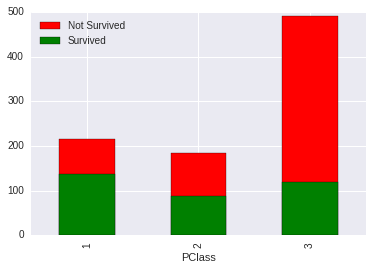

In [12]:
pbc_total = passengers_by_class["Survived"].count()
pbc_survived = passengers_by_class["Survived"].sum()

pbc_total.plot(kind="bar", color="r", label="Not Survived")
pbc_survived.plot(kind="bar", color="g", label="Survived")
plt.legend(loc=2)

#### Who was more likely to survive, males or females?
Most of the passengers were males (65%), and the average age for males was 30.7, while for females it was 27.9.

In [13]:
passengers_by_sex = df.groupby("Sex")
passengers_by_sex.describe()

Age        Fare      PClass       ParCh  PassengerId  \
Sex                                                                         
female count  261.000000  314.000000  314.000000  314.000000   314.000000   
       mean    27.915709   44.479818    2.159236    0.649682   431.028662   
       std     14.110146   57.997698    0.857290    1.022846   256.846324   
       min      0.750000    6.750000    1.000000    0.000000     2.000000   
       25%     18.000000   12.071875    1.000000    0.000000   231.750000   
       50%     27.000000   23.000000    2.000000    0.000000   414.500000   
       75%     37.000000   55.000000    3.000000    1.000000   641.250000   
       max     63.000000  512.329200    3.000000    6.000000   889.000000   
male   count  453.000000  577.000000  577.000000  577.000000   577.000000   
       mean    30.726645   25.523893    2.389948    0.235702   454.147314   
       std     14.678201   43.138263    0.813580    0.612294   257.486139   
       min      0.420000    0.000000    1.000000    0.000000     1.000000   
       25%     21.000000    7.895800    2.000000    0.000000   222.000000   
       50%     29.000000   10.500000    3.000000    0.000000   464.000000   
       75%     39.000000   26.550000    3.000000    0.000000   680.000000   
       max     80.000000  512.329200    3.000000    5.000000   891.000000   

                   SibSp  Survived  
Sex                                 
female count  314.000000       314  
       mean     0.694268  0.742038  
       std      1.156520  0.438211  
       min      0.000000     False  
       25%      0.000000         0  
       50%      0.000000         1  
       75%      1.000000         1  
       max      8.000000      True  
male   count  577.000000       577  
       mean     0.429809  0.188908  
       std      1.061811  0.391775  
       min      0.000000     False  
       25%      0.000000         0  
       50%      0.000000         0  
       75%      0.000000         0  
       max      8.000000      True

In [14]:
# function to write some text in a certain (x, y) point
def label(xy, text, x_offset=.7, y_offset=0, size=18, rotation="horizontal"):
    x = xy[0] - x_offset
    y = xy[1] - y_offset
    plt.text(x, y, text, ha="center", va="center", family="sans-serif", size=size, rotation=rotation)
    
# function that calculates the radius of a circle starting from the area
def radius(area):
    return np.sqrt(area/np.pi)

# function that shows the difference between two numbers using two layered circles of different areas
def bubble(total, part, title="", desc_outer="", desc_inner=""):
    grid = np.mgrid[0.1:2.0:2j, 0.1:2.0:1j].reshape(2, -1).T
    fig, ax = plt.subplots(figsize=(3,3))
    
    r_outer = radius(1)
    r_inner = radius(part / float(total))

    # create the two circles 
    outer_circle = mpatches.Circle(grid[0], r_outer, color="r")
    position_inner = (grid[0][0], grid[0][1] - (r_outer - r_inner))   # calculate the position of the center of the inner circle
    inner_circle = mpatches.Circle(position_inner, r_inner, color="g")

    ax.add_patch(outer_circle)        
    ax.add_patch(inner_circle)

    # add the title and the descriptions
    label(grid[0], desc_outer, 0, -.64)
    label(grid[0], desc_inner, 0, 0.64)
    label(grid[0], title, size=24, rotation="vertical")
    
    # remove the axis and show the result
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis("equal")
    plt.axis("off")
    plt.show()

Females survived in greatest number (74.2%), while males had a really low survival rate (18.9%), this strongly suggests that a *women and children first* policy was used when evacuating the passengers.

The bubble charts below show the total ammount of passengers of each gender and the related *Survived* count.

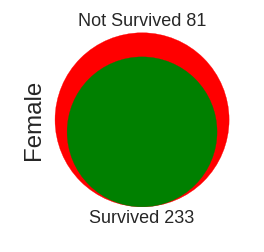

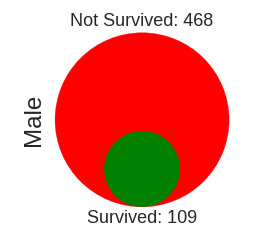

In [15]:
# group the passengers that survived by gender
survived_by_sex = df.groupby("Sex") 

# find the values and labels for the area circles
total = survived_by_sex["Survived"].count()
survived = survived_by_sex["Survived"].sum().astype(int)
perished = (total - survived).astype(int)
titles = ["Female", "Male"]
outer_descriptions = ["Not Survived " + str(perished["female"]), "Not Survived: " + str(perished["male"])]
inner_descriptions = ["Survived " + str(survived["female"]), "Survived: " + str(survived["male"])]

# show the difference using bubble charts
bubble(total[0], survived[0], titles[0], outer_descriptions[0], inner_descriptions[0])
bubble(total[1], survived[1], titles[1], outer_descriptions[1], inner_descriptions[1])

####  Is there a particular age range that tended to survive most?
From the following histogram it can be noticed that the passengers that tended to survive more were the ones between 20 to 35 years old. That age range was also the one that was present in biggest number, so that could be the reason for them to survive more. To prove that it wasn't  due to this reason a correlation test could be done.

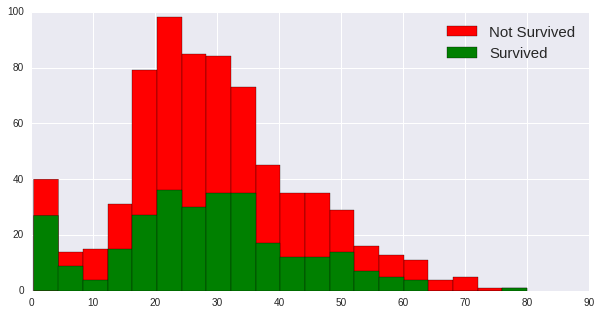

In [16]:
plt.figure(figsize=(10, 5))

# histogram containing ages from all the passengers
known_age_passengers["Age"].hist(bins=20, color="r", label="Not Survived")
# histogram containing ages from the survived passengers
known_age_passengers["Age"][known_age_passengers["Survived"]].hist(bins=20, color="g", label="Survived")

plt.legend(prop={"size":15})
plt.show()

The correlation test shows indeed that there's no correlation between survival and age in this particular case.

In [17]:
# distance of each value from the mean in standard units
age_diff = (known_age_passengers["Age"] - known_age_passengers["Age"].mean()) / known_age_passengers["Age"].std()
survived_diff = (known_age_passengers["Survived"] - known_age_passengers["Survived"].mean()) / known_age_passengers["Survived"].std()

# Pearson's r
(age_diff * survived_diff).mean()

-0.0771129417786591

#### How did survival rate change across different decks of the ship?
Passengers had cabins assigned between decks A and G, but there's also one passenger that was staying in the Boat Deck, and this person was most likely part of the crew working on that deck, since that deck had cabins just for crew members. The Boat Deck was the highest deck and it was also the one from which lifeboats could be launched.

In [18]:
def polar_chart(heights, labels, colors):
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(polar=True)
    
    # calculate the width and starting position of each bar
    width = (heights[0] / float(heights[0].sum())) * (2* np.pi)
    theta = np.array([0.0]*len(width))
    for i in range(len(width)-1):
        theta[i+1] = theta[i] + width[i]
    
    # create the background bar and the border containing the labels
    ax.bar(theta, [heights[0].max() +20]*len(heights[0]), width=width, color="black", alpha=.5)
    ax.bar(theta, [heights[0].max() + 5]*len(heights[0]), width=width, color="w", alpha=.5)
    
    # create the bars
    for i in range(len(heights)):
        ax.bar(theta, heights[i], width=width, label=labels[i], color=colors[i])
        
    # add the labels
    for i in range(len(width)):
        x = theta[i] + width[i]/2.0
        y = heights[0].max() + 12
        text = heights[0].index[i] + "\n" + str(heights[1][i] / float(heights[0][i]))[1:4]
        r = 360 * x / (theta[-1]+width[-1]) - 90
        ax.text(x, y, text, ha="center", va="center", size=20, rotation=r, fontweight='bold')
    
    # attach the legend, remove the axis and show the result
    ax.legend(bbox_to_anchor=(1.05, 1), loc = 2, prop={"size":15})
    plt.axis("off")
    plt.show()

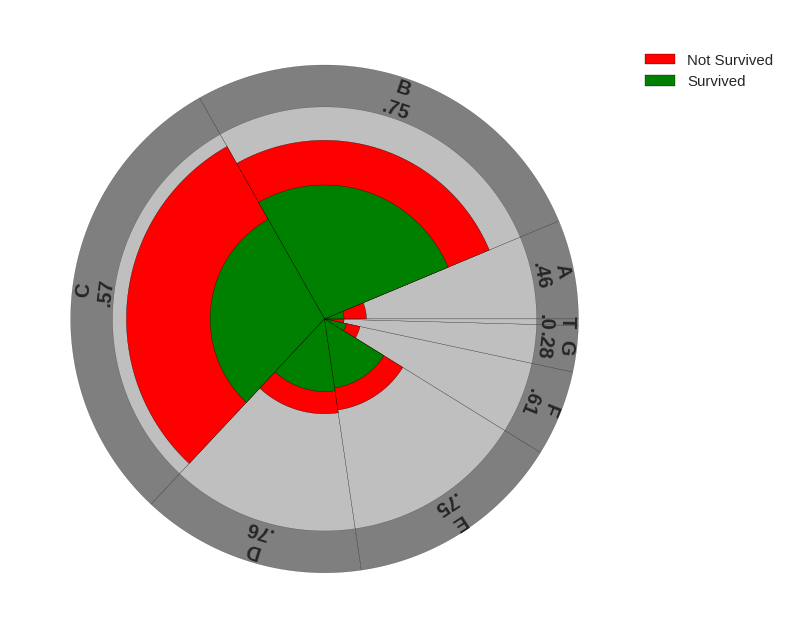

In [19]:
passengers_by_deck = known_cabin_passengers.groupby("Deck")

# total number of passengers grouped by deck 
total_deck = passengers_by_deck.count()["Survived"]
# number of survived passengers grouped by deck
survived_deck = passengers_by_deck.sum()["Survived"]

polar_chart([total_deck, survived_deck], ["Not Survived", "Survived"], ["r", "g"])

The above chart has slices representing the number of passengers on a deck as radius, the proportion between that number and the total number of passengers on the ship (passengers that have a *Deck*) as width of the slices and each slice is split in two parts showing the number of passengers survived and passengers who didn't survive. Below the deck names there's labels indicating the ratio of passengers survived on that deck. 

It can be noticed that the majority of the passengers had cabins on deck C and B, and most decks have a survival rate above .50, even though just 31.9% passengers survived (710 out of 2224). The problem here is that we have information about assigned cabins of a really small part of the whole population, and this information is not even random, since most of it comes from the incomplete first class passenger list recovered with the body of steward Herbert Cave. This data is then not reliable and can't be used to answer this question.

If I'm allowed to speculate, with a random sample I would have expected to see more people on lower decks being 3rd class passengers, and I would have expected them to have a lower survival rate since they were farther away from the lifeboats and by the time they would have got there could have been no lifeboat left.

## Conclusion

#### Limitations
While using the Titanic dataset I found several limitations that made making deeper analysis more difficult and in some cases unreliable. 

The first limitation was the missing values, in the first two questions fortunately I was able to use the entire dataset because there was no missing values. However for the *Age* and *Cabin* columns there was respectively 177 and 687 values missing, in the first case it made the analysis about the relationship between *Age* and survival unreliable, because I don't know if those missing numbers are random or if it's a certain group of people that if counted could change the result of the analysis; while on the second case since most of the values were missing and the values missing were mostly data from 2nd and 3rd class passengers (the source for most of the cabin locations was an incomplete 1st class list), it made the analysis of that column unreliable and probably useless.

Also many passengers had more than one *Cabin* assigned, and  I'm not sure if that's because those passengers paid to get more cabins, they changed cabin during the journey or because it's not sure which of those cabins they had. When exploring that column I assumed that they paid for more than one cabin, but in case I'm wrong that would also compromise my analysis. 

Another thing, it would be nice to have some more variables. For example if everyone had a *Cabin* it would have been really interesting to also have the lifeboat number for each survived passenger. Then with another dataset containing information about the lifeboats like number, capacity and order of launch, it would be possible to calculate who got to the first lifeboat and who got to the last, and then we could get an idea of how passengers tended to move to evacuate the ship.
#### Summary
The major findings of this analysis are the following:

- Passengers travelling in 1st class tended to survive most (.63) while 3rd class passengers survived the least (.24), even though 3rd class passengers were present in biggest number (491).

- Females (74.2%) had a way higher rate of survival than males (18.9%).

- Passsengers with age between 20 and 35 tended to survive the most, but that's because they were present in biggest number, there's no actual relationship between age and survival rate.

- Data about *Decks* and *Cabins* is unreliable, therefore I can make no conclusion about it. 

## Sources
- [Useful Pandas Snippets](https://gist.github.com/bsweger/e5817488d161f37dcbd2)
- [Splitting rows on DataFrames](http://stackoverflow.com/questions/17116814/pandas-how-do-i-split-text-in-a-column-into-multiple-rows)
- [Matplotlib shapes and collections](http://matplotlib.org/examples/shapes_and_collections/artist_reference.html)
- [Matplotlib polarbar](http://matplotlib.org/examples/pie_and_polar_charts/polar_bar_demo.html)
- [Matplot polar labeling](http://stackoverflow.com/questions/24020202/python-matplotlib-polar-labeling)
- [Titanic Deckplans](http://www.encyclopedia-titanica.org/titanic-deckplans)
- [Cabin Allocations](http://www.encyclopedia-titanica.org/cabins.html)